# Parallel multi-agent pattern

Some complex tasks can be divided into independent subtasks that do not need to be executed in sequence. Just as a team of experts can work simultaneously on different aspects of a project without waiting for each other, AI agents can process different parts of a problem in parallel for greater efficiency.

The parallel multi-agent pattern is a workflow approach where multiple specialized independent agents work simultaneously on different, independent aspects of a problem. Each agent is a complete system with its own state and reasoning loop. Agents operate independently without dependencies on other agents' outputs, and their results are later aggregated or synthesized into a final answer. This pattern is particularly valuable for:
- Tasks that can be decomposed into independent subtasks.
- Problems requiring multiple perspectives or types of analysis.
- Scenarios where speed is important (parallel execution is faster than sequential).
- Situations where different aspects need different expertise.

In this notebook, we will implement a parallel multi-agent system for comprehensive topic analysis:
1. **Historical context agent** - Independent agent that analyzes historical background.
2. **Technical details agent** - Independent agent that examines technical aspects.
3. **Impact analysis agent** - Independent agent that evaluates impacts and implications.
4. **Parallel coordinator** - Orchestrates parallel execution and aggregates results.

This demonstrates how multiple independent agents can work simultaneously on complementary aspects of a problem, then combine their findings for a richer, more complete understanding.

In [1]:
import os
import asyncio
from typing import TypedDict, Sequence, Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
import wikipedia
import json

### Initialize the language model

In a parallel system, each agent works independently with its own specialized focus. We use the same base model for all agents but differentiate them through system prompts that define their specific analytical perspectives.

In [2]:
# Initialize the OpenAI language model
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.0)

We use `temperature=0.7` to allow some variation and creativity across the parallel agents. Since they are analyzing different aspects, we want each to bring its own perspective.

### Define tools
Parallel agents may need access to information sources to complete their analyses. We provide tools that enable information gathering.

#### Wikipedia search tool

In [3]:
@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia for the query and return a brief summary of the top result."""
    try:
        # Fetches summary from Wikipedia for the given query (limited to 5 sentences)
        summary = wikipedia.summary(query, sentences=5)
        return summary
    except Exception as e:
        # Return error if the query fails (e.g., disambiguation, page not found)
        return f"Error: {e}"

The Wikipedia tool enables each parallel agent to independently gather information relevant to its specific analytical focus.

#### Bind tools to model

In [4]:
# Collect tools and create a registry
tools = [wiki_search]
tools_by_name = {tool.name: tool for tool in tools}

# Create a tool-enabled LLM for agents that need external data
llm_with_tools = llm.bind_tools(tools)

We create a tool-enabled version of the LLM that parallel agents can use to gather information independently.

### Build independent parallel agents
Now we create separate, independent agents for each analytical dimension. Each agent is a complete, self-contained system with its own state and graph.

#### Historical context agent
The historical context agent is an independent agent specialized in analyzing historical background and context.

In [5]:
# Define state for the historical context agent
class HistoricalAgentState(TypedDict):
    """State for the independent Historical Context Agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    topic: str  # The topic to analyze
    analysis: str  # The historical analysis

def historical_agent_work(state: HistoricalAgentState):
    """Historical context agent: Analyze historical background."""
    
    # System prompt defines this agent's analytical focus
    system_prompt = SystemMessage(
        content="""You are an independent Historical Context Agent.
        
        Your specific focus: Historical background and context
        - When did this topic emerge or become important?
        - What historical events or conditions led to it?
        - How has it evolved over time?
        - What is the historical significance?
        
        Use tools if needed. Focus only on historical aspects.
        """
    )
    
    # Get the topic
    topic = state["topic"]
    
    # Create analysis task
    task_message = HumanMessage(content=f"Analyze the historical context of: {topic}")
    
    # Execute analysis with tool access
    response = llm_with_tools.invoke([system_prompt, task_message])
    
    # Process tool calls if any
    analysis_text = response.content if response.content else ""
    
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            
            # Execute the tool
            if tool_name in tools_by_name:
                result = tools_by_name[tool_name].invoke(tool_args)
            else:
                result = f"Tool '{tool_name}' not found."
            
            # Incorporate tool results
            analysis_text += f"\n\nHistorical Data: {result}"
    
    return {
        "messages": [AIMessage(content=analysis_text)],
        "analysis": analysis_text
    }

# Build the historical context agent graph
historical_graph = StateGraph(HistoricalAgentState)
historical_graph.add_node("analyze", historical_agent_work)
historical_graph.add_edge(START, "analyze")
historical_graph.add_edge("analyze", END)

# Compile the historical context agent as an independent agent
historical_agent = historical_graph.compile()

The historical context agent is now a complete, independent agent that analyzes historical dimensions.

#### Technical details agent
The technical details agent is an independent agent specialized in examining technical aspects and mechanisms.

In [6]:
# Define state for the technical details agent
class TechnicalAgentState(TypedDict):
    """State for the independent Technical Details Agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    topic: str  # The topic to analyze
    analysis: str  # The technical analysis

def technical_agent_work(state: TechnicalAgentState):
    """Technical details agent: Analyze technical aspects."""
    
    # System prompt defines this agent's analytical focus
    system_prompt = SystemMessage(
        content="""You are an independent Technical Details Agent.
        
        Your specific focus: Technical aspects and mechanisms
        - How does it work technically?
        - What are the key components or mechanisms?
        - What technical principles are involved?
        - What are the technical specifications or details?
        
        Use tools if needed. Focus only on technical aspects.
        """
    )
    
    # Get the topic
    topic = state["topic"]
    
    # Create analysis task
    task_message = HumanMessage(content=f"Analyze the technical details of: {topic}")
    
    # Execute analysis with tool access
    response = llm_with_tools.invoke([system_prompt, task_message])
    
    # Process tool calls if any
    analysis_text = response.content if response.content else ""
    
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            
            # Execute the tool
            if tool_name in tools_by_name:
                result = tools_by_name[tool_name].invoke(tool_args)
            else:
                result = f"Tool '{tool_name}' not found."
            
            # Incorporate tool results
            analysis_text += f"\n\nTechnical Data: {result}"
    
    return {
        "messages": [AIMessage(content=analysis_text)],
        "analysis": analysis_text
    }

# Build the technical details agent graph
technical_graph = StateGraph(TechnicalAgentState)
technical_graph.add_node("analyze", technical_agent_work)
technical_graph.add_edge(START, "analyze")
technical_graph.add_edge("analyze", END)

# Compile the technical details agent as an independent agent
technical_agent = technical_graph.compile()

The technical details agent is now a complete, independent agent that analyzes technical aspects.

#### Impact analysis agent
The impact analysis agent is an independent agent specialized in evaluating impacts and implications.

In [7]:
# Define state for the impact analysis agent
class ImpactAgentState(TypedDict):
    """State for the independent Impact Analysis Agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    topic: str  # The topic to analyze
    analysis: str  # The impact analysis

def impact_agent_work(state: ImpactAgentState):
    """Impact analysis agent: Analyze impacts and implications."""
    
    # System prompt defines this agent's analytical focus
    system_prompt = SystemMessage(
        content="""You are an independent Impact Analysis Agent.
        
        Your specific focus: Impacts and implications
        - What are the effects and consequences?
        - Who or what is impacted?
        - What are the broader implications?
        - What are the positive and negative impacts?
        
        Use tools if needed. Focus only on impacts.
        """
    )
    
    # Get the topic
    topic = state["topic"]
    
    # Create analysis task
    task_message = HumanMessage(content=f"Analyze the impacts of: {topic}")
    
    # Execute analysis with tool access
    response = llm_with_tools.invoke([system_prompt, task_message])
    
    # Process tool calls if any
    analysis_text = response.content if response.content else ""
    
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            
            # Execute the tool
            if tool_name in tools_by_name:
                result = tools_by_name[tool_name].invoke(tool_args)
            else:
                result = f"Tool '{tool_name}' not found."
            
            # Incorporate tool results
            analysis_text += f"\n\nImpact Data: {result}"
    
    return {
        "messages": [AIMessage(content=analysis_text)],
        "analysis": analysis_text
    }

# Build the impact analysis agent graph
impact_graph = StateGraph(ImpactAgentState)
impact_graph.add_node("analyze", impact_agent_work)
impact_graph.add_edge(START, "analyze")
impact_graph.add_edge("analyze", END)

# Compile the impact analysis agent as an independent agent
impact_agent = impact_graph.compile()

The impact analysis agent is now a complete, independent agent that analyzes impacts and implications.

### Build the parallel coordinator
Now we create the parallel coordinator that orchestrates the simultaneous execution of all agents using `asyncio` and aggregates their results.

In [8]:
# Define state for the parallel coordinator
class ParallelCoordinatorState(TypedDict):
    """State for the Parallel Coordinator that orchestrates parallel agents."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_question: str  # The original user question
    historical_analysis: str  # Output from historical agent
    technical_analysis: str  # Output from technical agent
    impact_analysis: str  # Output from impact agent
    final_synthesis: str  # Aggregated result

async def parallel_execution(state: ParallelCoordinatorState):
    """Execute all three agents in parallel using asyncio."""
    
    topic = state["user_question"]
    
    # Create the input states for all three agents
    historical_input = {
        "messages": [],
        "topic": topic,
        "analysis": ""
    }
    
    technical_input = {
        "messages": [],
        "topic": topic,
        "analysis": ""
    }
    
    impact_input = {
        "messages": [],
        "topic": topic,
        "analysis": ""
    }
    
    # Execute all three agents in parallel using asyncio.gather - This allows true concurrent execution
    historical_result, technical_result, impact_result = await asyncio.gather(
        historical_agent.ainvoke(historical_input),
        technical_agent.ainvoke(technical_input),
        impact_agent.ainvoke(impact_input)
    )
    
    return {
        "messages": [AIMessage(content="[Parallel Execution] All agents completed")],
        "historical_analysis": historical_result["analysis"],
        "technical_analysis": technical_result["analysis"],
        "impact_analysis": impact_result["analysis"]
    }

def aggregate_results(state: ParallelCoordinatorState):
    """Aggregate all parallel analyses into a comprehensive response."""
    
    # System prompt for aggregation
    system_prompt = SystemMessage(
        content="""You are an Aggregator synthesizing analyses from multiple specialists.
        
        You have received:
        - Historical context analysis
        - Technical details analysis
        - Impact analysis
        
        Your task: Combine these perspectives into a comprehensive, well-organized response.
        - Integrate insights from all three dimensions
        - Create a coherent narrative that connects the analyses
        - Provide a complete answer to the user's question
        """
    )
    
    # Get all analyses
    user_question = state["user_question"]
    historical = state["historical_analysis"]
    technical = state["technical_analysis"]
    impact = state["impact_analysis"]
    
    # Create aggregation prompt
    aggregation_prompt = HumanMessage(
        content=f"""Original Question: {user_question}
        
        Historical Context:
        {historical}
        
        Technical Details:
        {technical}
        
        Impact Analysis:
        {impact}
        
        Synthesize these analyses into a comprehensive response."""
    )
    
    # Execute aggregation
    response = llm.invoke([system_prompt, aggregation_prompt])
    
    synthesis_text = response.content
    
    return {
        "messages": [AIMessage(content=synthesis_text)],
        "final_synthesis": synthesis_text
    }

# Build the parallel coordinator graph
coordinator_graph = StateGraph(ParallelCoordinatorState)

# Add nodes for parallel execution and aggregation
coordinator_graph.add_node("execute_parallel", parallel_execution)
coordinator_graph.add_node("aggregate", aggregate_results)

# Define the workflow
coordinator_graph.add_edge(START, "execute_parallel")
coordinator_graph.add_edge("execute_parallel", "aggregate")
coordinator_graph.add_edge("aggregate", END)

# Compile the parallel coordinator
parallel_coordinator = coordinator_graph.compile()

The parallel coordinator orchestrates the execution of all three independent agents and aggregates their results into a comprehensive response.
- The coordinator uses `asyncio.gather()` to invoke all three agents simultaneously, achieving parallelism rather than sequential execution. This significantly improves performance when agents are independent and do not depend on each other's outputs.

### Visualize the workflow

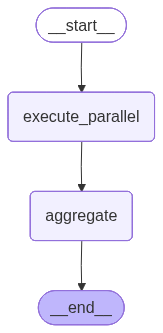

In [9]:
# Visualize the Parallel Coordinator's workflow
display(
    Image(
        parallel_coordinator.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run an example

Let's see the parallel multi-agent pattern in action with a topic that benefits from multiple analytical perspectives.

In [10]:
# Example: A topic that benefits from multi-dimensional analysis
user_question = "Explain artificial intelligence and its significance."

# Initialize the Parallel Coordinator
initial_state = ParallelCoordinatorState(
    messages=[HumanMessage(content=user_question)],
    user_question=user_question,
    historical_analysis="",
    technical_analysis="",
    impact_analysis="",
    final_synthesis=""
)

# Run the parallel multi-agent system
print("=== Parallel Multi-Agent Pattern Execution ===")
print(f"\nUser Question: {user_question}\n")
print("Executing three agents in parallel...\n")

# Use ainvoke for async execution
result = await parallel_coordinator.ainvoke(initial_state)

# Display the results from each agent
print("\n=== Parallel Agent Analyses ===")
print("\n[Historical Context Agent]:")
print(result["historical_analysis"][:300] + "...\n")

print("[Technical Details Agent]:")
print(result["technical_analysis"][:300] + "...\n")

print("[Impact Analysis Agent]:")
print(result["impact_analysis"][:300] + "...\n")

print("\n=== Final Comprehensive Synthesis ===")
print(result["final_synthesis"])

=== Parallel Multi-Agent Pattern Execution ===

User Question: Explain artificial intelligence and its significance.

Executing three agents in parallel...


=== Parallel Agent Analyses ===

[Historical Context Agent]:


Historical Data: The history of artificial intelligence (AI) began in antiquity, with myths, stories, and rumors of artificial beings endowed with intelligence or consciousness by master craftsmen. The study of logic and formal reasoning from antiquity to the present led directly to the invention ...

[Technical Details Agent]:


Technical Data: Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and stud...

[Impact Analysis Agent]:


Impact Data: Artificial intelligence (AI) is the capability of computational systems to perform tasks typically assoc

In this example, we see true parallel multi-agent collaboration:
1. **Historical context agent** (independent agent) analyzes when and how AI emerged.
2. **Technical details agent** (independent agent) explains how AI works and what mechanisms are involved.
3. **Impact analysis agent** (independent agent) evaluates AI's effects on society and various domains.

All three agents work independently with their own state and reasoning loops. The parallel coordinator orchestrates them by invoking all three agents in parallel (since they do not depend on each other), then aggregating their results. This demonstrates the parallel pattern where independent specialized agents analyze different dimensions simultaneously, producing a richer, more complete answer than any single agent could provide.